In [1]:
# Library imports

from deap import algorithms, base, creator, tools
from factor_analyzer import FactorAnalyzer
from itertools import combinations, combinations_with_replacement
from matplotlib.patches import Ellipse
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from pyDOE2 import ccdesign, fullfact
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from scipy import stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.optimize import minimize
from scipy.spatial import distance
from scipy.spatial.distance import mahalanobis
from scipy.special import entr
from scipy.stats import qmc, t
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from statsmodels.tools.tools import add_constant
import itertools
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Creation of the CCD

# Number of factors
k = 4

# Creating the CCD with 1 center point in the factorials and 1 center point in the axials
design = ccdesign(k, center=(1, 0))

# Adjusting the values of the factorial points to -1 and 1
factorial_points = np.around(design[:2**k], 4)

# Defining the axial points to have alpha = 2
alpha = 2
axial_points = np.zeros((2 * k, k))
for i in range(k):
    axial_points[2 * i, i] = -alpha
    axial_points[2 * i + 1, i] = alpha

# Creating the central point
central_point = np.zeros((1, k))

# Combining the factorial, axial, and central points
combined_design = np.vstack([factorial_points, axial_points, central_point])

# Transforming the design into a DataFrame for better visualization
df = pd.DataFrame(combined_design, columns=[f'x{i+1}' for i in range(k)])

# Exclusion of experiments - if necessary

# Excluding row 17
df = df.drop(16)

# Resetting the indices after exclusion
df = df.reset_index(drop=True)

# Visualizing the DOE with the coded data
print("DOE coded:")
df

# Saving the DOE to an Excel file
# df.to_excel("doe_coded.xlsx", index=False)

DOE coded:


,x1,x2,x3,x4
0,-1.0,-1.0,-1.0,-1.0
1,1.0,-1.0,-1.0,-1.0
2,-1.0,1.0,-1.0,-1.0
3,1.0,1.0,-1.0,-1.0
4,-1.0,-1.0,1.0,-1.0
5,1.0,-1.0,1.0,-1.0
6,-1.0,1.0,1.0,-1.0
7,1.0,1.0,1.0,-1.0
8,-1.0,-1.0,-1.0,1.0
9,1.0,-1.0,-1.0,1.0


In [3]:
# Decoding the variables

# Ranges and real means for each variable
intervals = {'x1': (6, 14), 'x2': (0, 30), 'x3': (0, 90), 'x4': (26, 40)}

# Decoding the data to create the new DataFrame
df_decoded = df.copy()
for variable, interval in intervals.items():
    mean = sum(interval) / 2
    df_decoded[variable] = df_decoded[variable] * ((interval[1] - interval[0]) / 2) + mean

# Visualizing the DataFrame with the decoded data
print("DOE decoded:")
df_decoded

# Saving the DataFrame to an Excel file
# df_uncod.to_excel("doe_decoded.xlsx", index=False)

DOE decoded:


,x1,x2,x3,x4
0,6.0,0.0,0.0,26.0
1,14.0,0.0,0.0,26.0
2,6.0,30.0,0.0,26.0
3,14.0,30.0,0.0,26.0
4,6.0,0.0,90.0,26.0
5,14.0,0.0,90.0,26.0
6,6.0,30.0,90.0,26.0
7,14.0,30.0,90.0,26.0
8,6.0,0.0,0.0,40.0
9,14.0,0.0,0.0,40.0


In [4]:
# Inclusion of output variables

# Creating the DataFrame directly from the responses dictionary
responses_df = pd.read_excel("responses.xlsx")

# Visualizing the Dataset
round(responses_df.head(), 3)

,BM,MFR,T,PI,MC,MTP,MMV,ATε
0,7.620,21.437,14.992,35.924,9.712,3.665,8.039,7.417
1,7.620,26.635,23.532,39.176,11.563,4.108,9.160,9.539
2,9.280,21.907,21.555,34.340,10.045,6.247,10.616,11.104
3,9.280,25.849,35.093,36.647,12.338,6.981,12.295,16.762
4,8.316,22.291,16.806,36.174,9.866,6.970,10.674,7.922


In [5]:
# Correlation and Covariance

# Calculating the correlation and covariance matrices
correlation_matrix = responses_df.corr()
covariance_matrix = responses_df.cov()

# Creating a mask for the lower diagonal
correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
covariance_mask = np.triu(np.ones_like(covariance_matrix, dtype=bool))

# Applying the mask and replacing upper values with empty strings
masked_correlation_matrix = np.where(correlation_mask, '', np.around(correlation_matrix, 3).astype(str))
masked_covariance_matrix = np.where(covariance_mask, '', np.around(covariance_matrix, 3).astype(str))

# Displaying the matrices
print("=" * 65)
print("\033[1m{:^65}\033[0m".format("Correlation Matrix"))  # \033[1m for bold, ^ for centering
print("=" * 65)
print("\n".join(["\t".join(row) for row in masked_correlation_matrix]))
print("\n")
print("=" * 65)
print("\033[1m{:^65}\033[0m".format("Covariance Matrix"))  # \033[1m for bold, ^ for centering
print("=" * 65)
print("\n".join(["\t".join(row) for row in masked_covariance_matrix]))

# Saving the correlation and covariance matrices to an Excel file
# with pd.ExcelWriter('correlation_covariance.xlsx') as writer:
#     correlation_matrix.to_excel(writer, sheet_name='Correlation Matrix')
#     covariance_matrix.to_excel(writer, sheet_name='Covariance Matrix')

                       Correlation Matrix                        
							
0.052							
0.248	0.876						
-0.075	0.977	0.783					
0.728	0.451	0.549	0.329				
0.304	0.577	0.767	0.473	0.269			
0.326	0.682	0.865	0.56	0.425	0.94		
0.36	0.485	0.801	0.341	0.491	0.715	0.802	


                        Covariance Matrix                        
							
0.972							
9.988	51.886						
-1.355	26.114	44.787					
5.337	4.855	12.658	3.425				
2.268	6.327	18.002	5.004	1.148			
2.399	7.37	19.976	5.837	1.785	4.021		
5.391	10.666	37.691	7.249	4.201	6.225	6.881	


In [6]:
# Principal Components Analysis and Factor Analysis

# Standardizing the data
scaler = StandardScaler()
responses_df_standardized = scaler.fit_transform(responses_df)

# Instantiating the PCA model with the total number of components
pca = PCA(n_components=len(responses_df.columns))
pca.fit(responses_df_standardized)

# Obtaining the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Obtaining the cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Determining the minimum number of components that explain at least 90% of the variance
n_components = np.sum(cumulative_variance <= 0.90) + 1

# Instantiating the PCA model with the appropriate number of components
pca = PCA(n_components=n_components)
pca.fit(responses_df_standardized)

# Obtaining the adjusted eigenvalues
eigenvalues = pca.explained_variance_
eigenvalues_adjusted = eigenvalues * (len(responses_df_standardized) - 1) / len(responses_df_standardized)

# Obtaining the proportion of variance explained by each principal component
proportion_explained = pca.explained_variance_ratio_

# Obtaining the cumulative explained variance
cumulative_variance = proportion_explained.cumsum()

# Printing the results
print("Eigenvalues:")
for i, eigenvalue in enumerate(eigenvalues_adjusted):
    print(f"PC{i+1}: {eigenvalue:.3f}")

print("\nProportion of Variance Explained:")
for i, proportion in enumerate(proportion_explained):
    print(f"PC{i+1}: {proportion:.3f}")

print("\nAccumulated Explained Variance:")
for i, variance in enumerate(cumulative_variance):
    print(f"PC{i+1}: {variance:.3f}")

# Obtaining the scores of the principal components
scores = pca.transform(responses_df_standardized)

# Converting the scores into a DataFrame for easier visualization
scores_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(n_components)])

# Showing the scores
print("\nPrincipal Components Scores:")
print(scores_df.round(3))


# Factor Analysis

# Instantiating the Factor Analysis model
fa = FactorAnalyzer(n_factors=n_components, rotation="varimax", method="principal")

# Fitting the model to the response variable data
fa.fit(responses_df)

# Obtaining the factor scores
scores_fa = fa.transform(responses_df)

# Converting the scores into a DataFrame
scoresfa_df = pd.DataFrame(scores_fa, columns=[f'F{i+1}' for i in range(n_components)])

# Obtaining the loadings of the rotated factors
rotated_loadings = fa.loadings_

# Converting the loadings into a DataFrame
df_rotated_loadings = pd.DataFrame(rotated_loadings, index=responses_df.columns, columns=[f'F{i+1}' for i in range(n_components)])

# Obtaining the communalities
communalities = fa.get_communalities()

# Converting the communalities into a DataFrame
df_communalities = pd.DataFrame(communalities, index=responses_df.columns, columns=["Communalities"])

# Concatenating the rotated factor loadings with the communalities
df_combined = pd.concat([df_rotated_loadings, df_communalities], axis=1)

# Function to sort DataFrames according to the description
def sort_loadings(df):
    # Initialize the list to store the sorted indices
    sorted_index = []
    
    # Sort by the absolute values in each factor, maintaining the desired pattern
    for factor in df.columns[:-1]:  # Exclude the communalities column
        # Filter rows with absolute value >= 0.65 in the current factor
        subset = df[abs(df[factor]) >= 0.65]
        # Sort the subset by the absolute value of the factor, in descending order
        sorted_subset = subset.sort_values(by=factor, ascending=False)
        # Add the indices to the result
        sorted_index.extend(sorted_subset.index)
    
    # Remove duplicates while maintaining the order
    sorted_index = list(dict.fromkeys(sorted_index))
    
    # Reorder the DataFrame based on the sorted indices
    df_sorted = df.loc[sorted_index]
    
    return df_sorted

# Sort the loadings based on the defined logic
df_sorted_combined = sort_loadings(df_combined)

# Showing the scores and the loadings:
print("\nSorted Rotated Factor Loading and Communalities:")
print(df_sorted_combined.round(3))
print("\nFactors Scores:")
print(scoresfa_df.round(3))

# Saving the DataFrame to an Excel file
# scores_df.to_excel("scores_pca.xlsx", index=False)
# scoresfa_df.to_excel("scores_fa.xlsx", index=False)

Eigenvalues:
PC1: 4.971
PC2: 1.552
PC3: 0.942

Proportion of Variance Explained:
PC1: 0.621
PC2: 0.194
PC3: 0.118

Accumulated Explained Variance:
PC1: 0.621
PC2: 0.815
PC3: 0.933

Principal Components Scores:
      PC1    PC2    PC3
0  -3.157 -1.071  0.166
1  -1.457 -1.242  0.787
2  -1.507 -0.464 -1.086
3   0.779 -0.274 -0.952
4  -1.754 -0.964 -0.925
5   1.619 -1.594 -0.452
6  -0.764 -0.441 -1.307
7   4.184 -1.239 -1.076
8  -2.203 -0.258  1.152
9  -0.741  0.052  1.873
10  0.370  1.125 -0.548
11 -0.393  2.435  0.511
12 -0.319 -0.194  0.021
13  1.990 -0.161  0.980
14  1.416  1.216 -0.781
15  5.761  0.261  1.323
16  3.557 -1.036  0.630
17 -1.863 -0.577  1.204
18  0.419  3.863 -1.295
19 -1.906  0.099  0.324
20 -3.383  1.212  0.772
21 -1.863 -1.124 -1.532
22  0.650  0.914  0.676
23  0.566 -0.538 -0.464

Sorted Rotated Factor Loading and Communalities:
        F1     F2     F3  Communalities
MTP  0.918  0.079  0.249          0.910
MMV  0.886  0.184  0.370          0.955
ATε  0.829  0.305  0

Analysis for response: BM
                            OLS Regression Results                            
Dep. Variable:                     BM   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     32.26
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           5.84e-06
Time:                        12:55:38   Log-Likelihood:                -16.932
No. Observations:                  24   AIC:                             63.86
Df Residuals:                       9   BIC:                             81.54
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      10.2979     

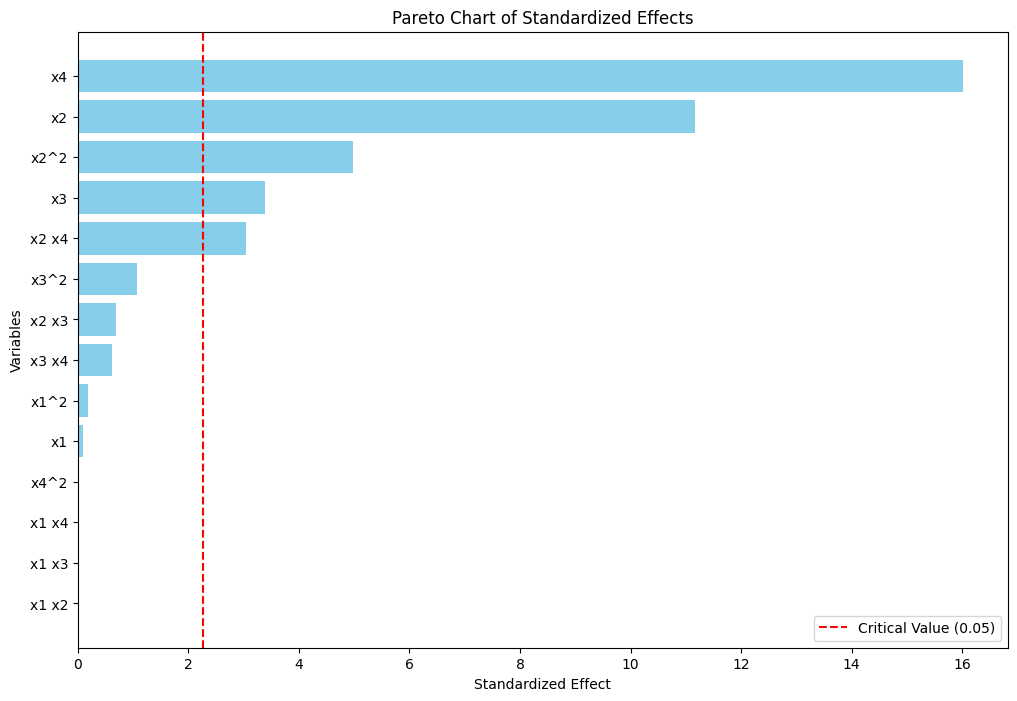

Analysis for response: MFR
                            OLS Regression Results                            
Dep. Variable:                    MFR   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     1.813
Date:                Sun, 13 Oct 2024   Prob (F-statistic):              0.186
Time:                        12:55:38   Log-Likelihood:                -57.317
No. Observations:                  24   AIC:                             144.6
Df Residuals:                       9   BIC:                             162.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      27.0057    

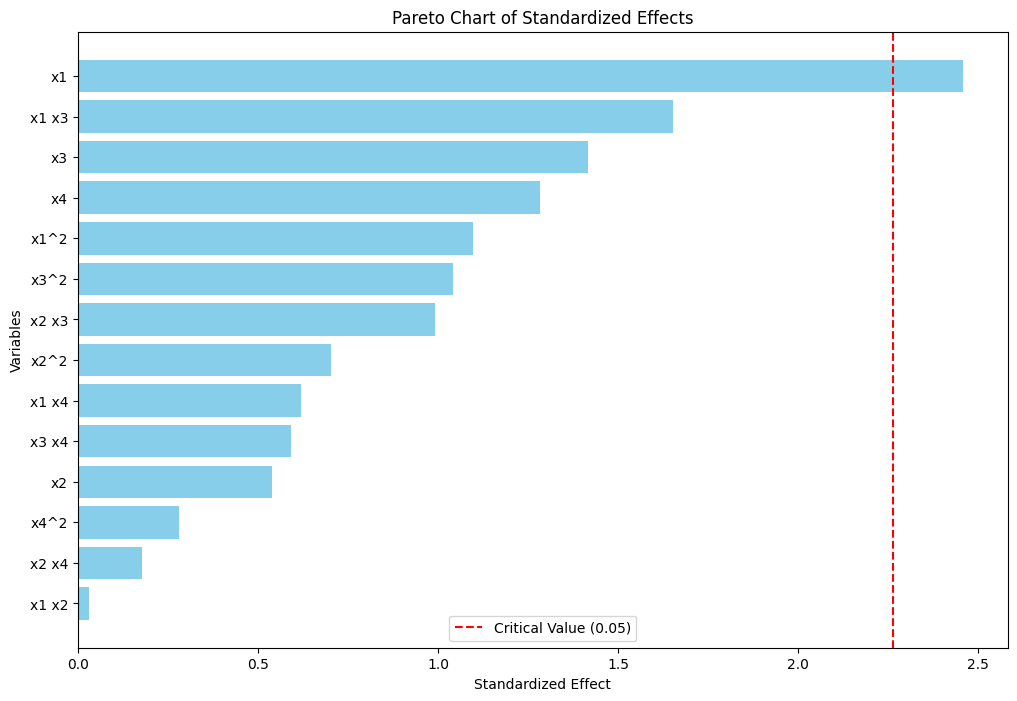

Analysis for response: T
                            OLS Regression Results                            
Dep. Variable:                      T   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     2.591
Date:                Sun, 13 Oct 2024   Prob (F-statistic):             0.0773
Time:                        12:55:38   Log-Likelihood:                -72.259
No. Observations:                  24   AIC:                             174.5
Df Residuals:                       9   BIC:                             192.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      33.5766      

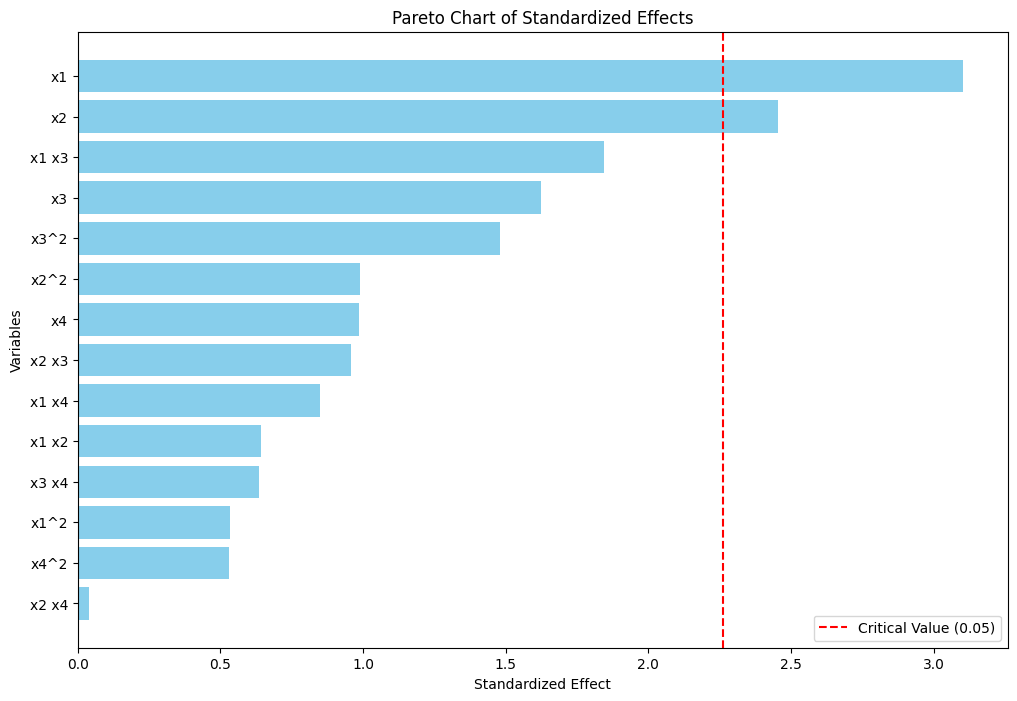

Analysis for response: PI
                            OLS Regression Results                            
Dep. Variable:                     PI   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     1.933
Date:                Sun, 13 Oct 2024   Prob (F-statistic):              0.161
Time:                        12:55:38   Log-Likelihood:                -55.888
No. Observations:                  24   AIC:                             141.8
Df Residuals:                       9   BIC:                             159.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      38.2221     

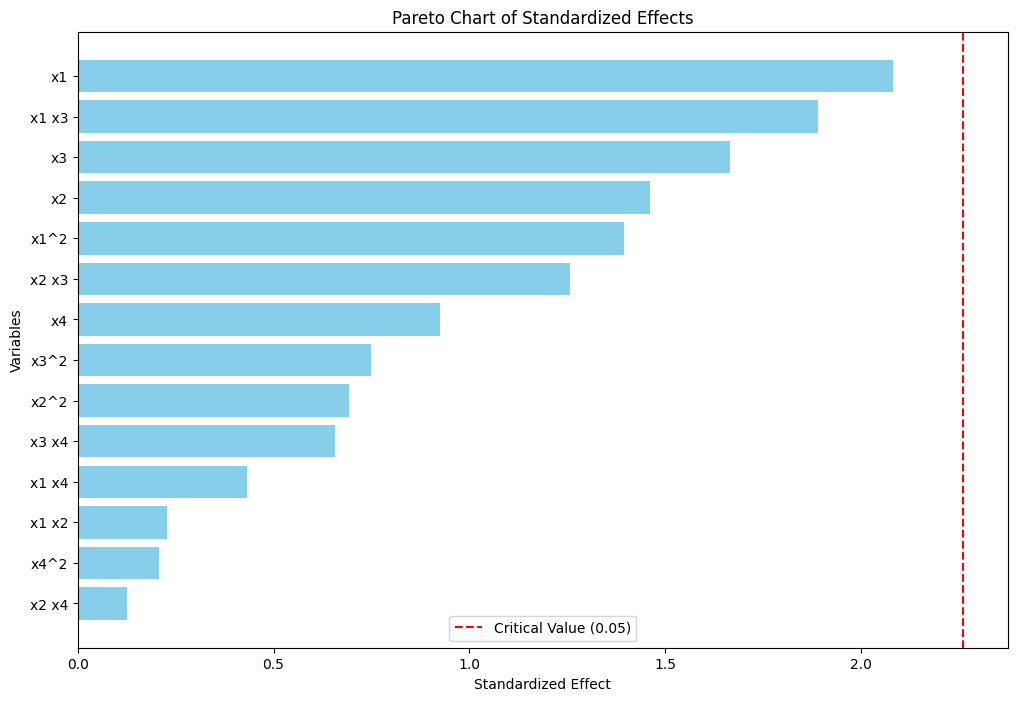

Analysis for response: MC
                            OLS Regression Results                            
Dep. Variable:                     MC   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     92.76
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           5.68e-08
Time:                        12:55:38   Log-Likelihood:                 9.0031
No. Observations:                  24   AIC:                             11.99
Df Residuals:                       9   BIC:                             29.66
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      12.0815     

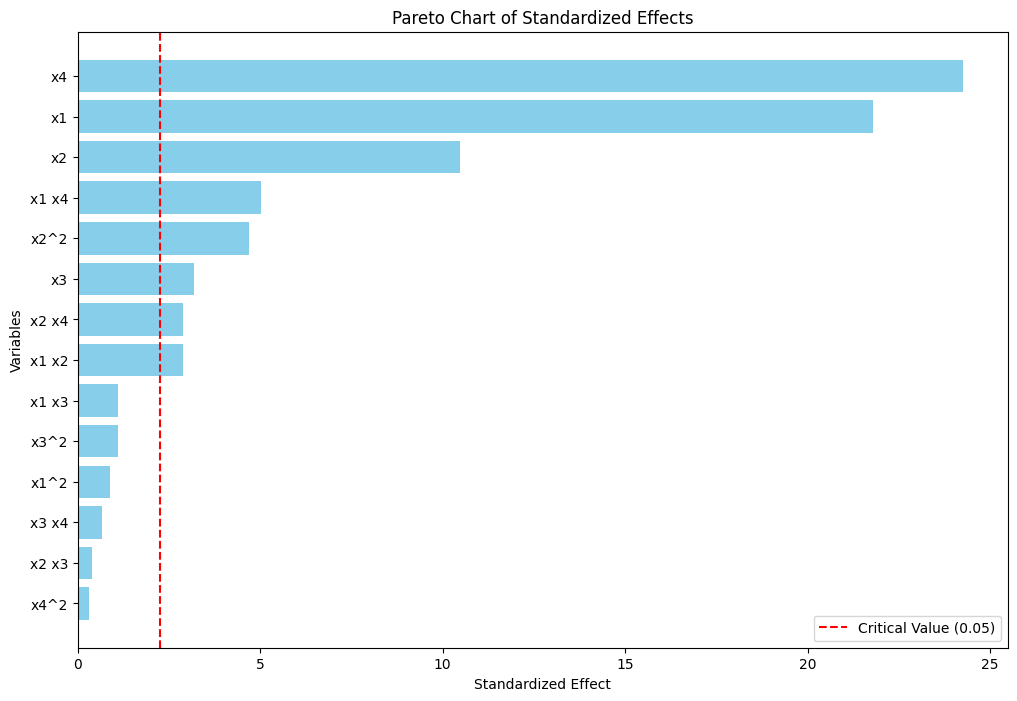

Analysis for response: MTP
                            OLS Regression Results                            
Dep. Variable:                    MTP   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     1.364
Date:                Sun, 13 Oct 2024   Prob (F-statistic):              0.326
Time:                        12:55:39   Log-Likelihood:                -37.502
No. Observations:                  24   AIC:                             105.0
Df Residuals:                       9   BIC:                             122.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       7.4381    

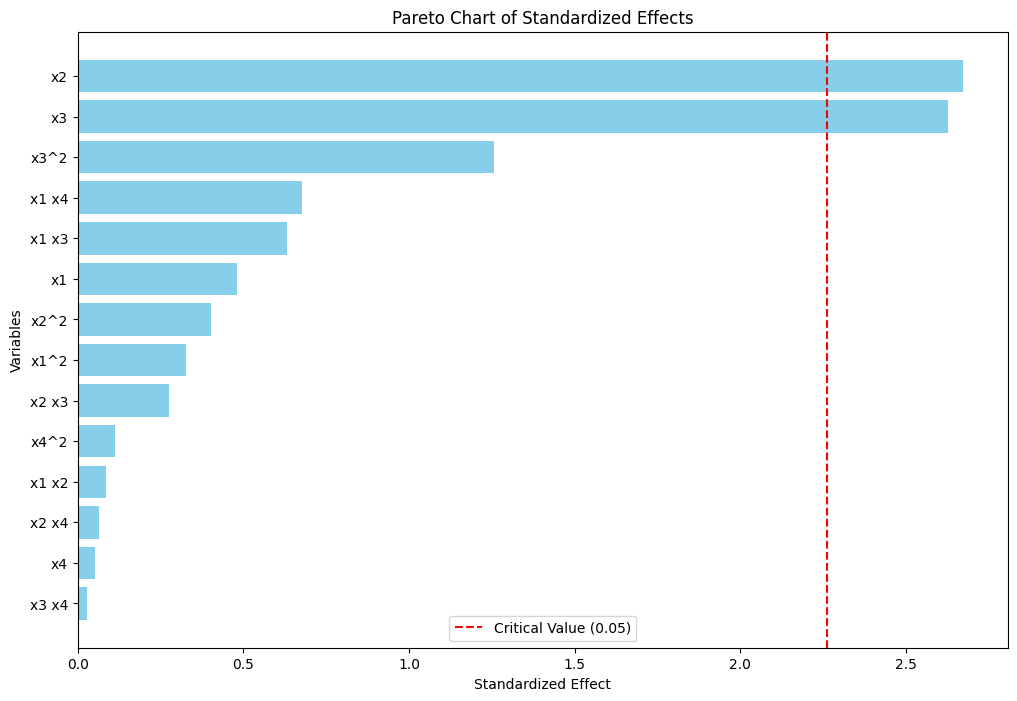

Analysis for response: MMV
                            OLS Regression Results                            
Dep. Variable:                    MMV   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     2.637
Date:                Sun, 13 Oct 2024   Prob (F-statistic):             0.0737
Time:                        12:55:39   Log-Likelihood:                -31.246
No. Observations:                  24   AIC:                             92.49
Df Residuals:                       9   BIC:                             110.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      12.3780    

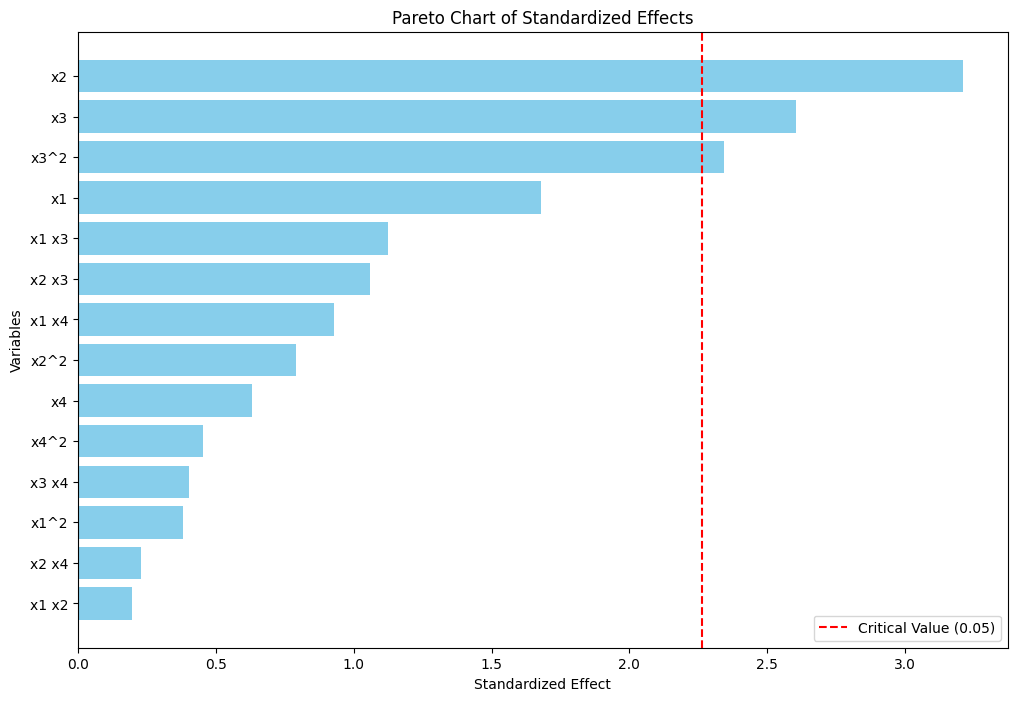

Analysis for response: ATε
                            OLS Regression Results                            
Dep. Variable:                    ATε   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     6.997
Date:                Sun, 13 Oct 2024   Prob (F-statistic):            0.00300
Time:                        12:55:39   Log-Likelihood:                -38.171
No. Observations:                  24   AIC:                             106.3
Df Residuals:                       9   BIC:                             124.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      11.5916    

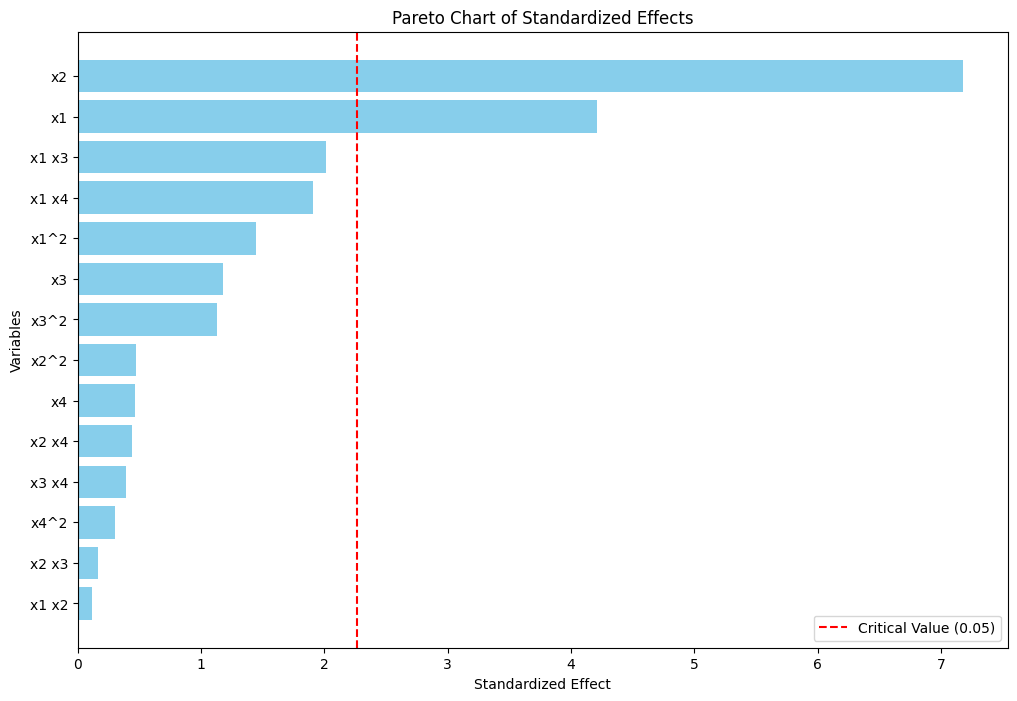

Analysis for response: F1
                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     3.322
Date:                Sun, 13 Oct 2024   Prob (F-statistic):             0.0379
Time:                        12:55:39   Log-Likelihood:                -12.224
No. Observations:                  24   AIC:                             54.45
Df Residuals:                       9   BIC:                             72.12
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.4805     

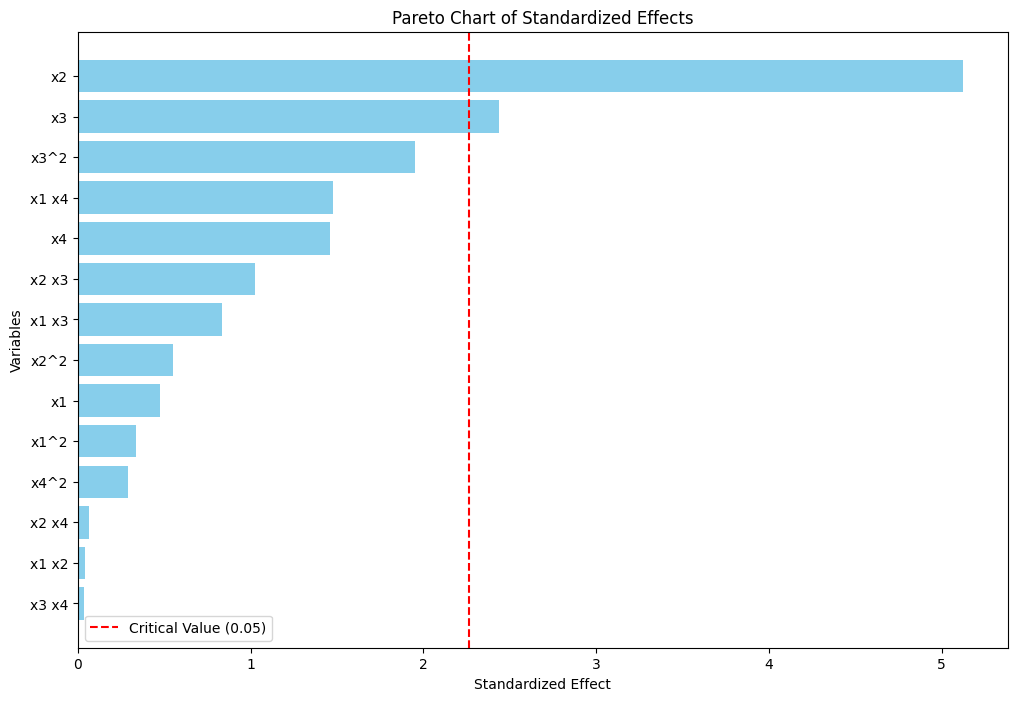

Analysis for response: F2
                            OLS Regression Results                            
Dep. Variable:                     F2   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     15.31
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           0.000137
Time:                        12:55:39   Log-Likelihood:                 4.4832
No. Observations:                  24   AIC:                             21.03
Df Residuals:                       9   BIC:                             38.70
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.4831     

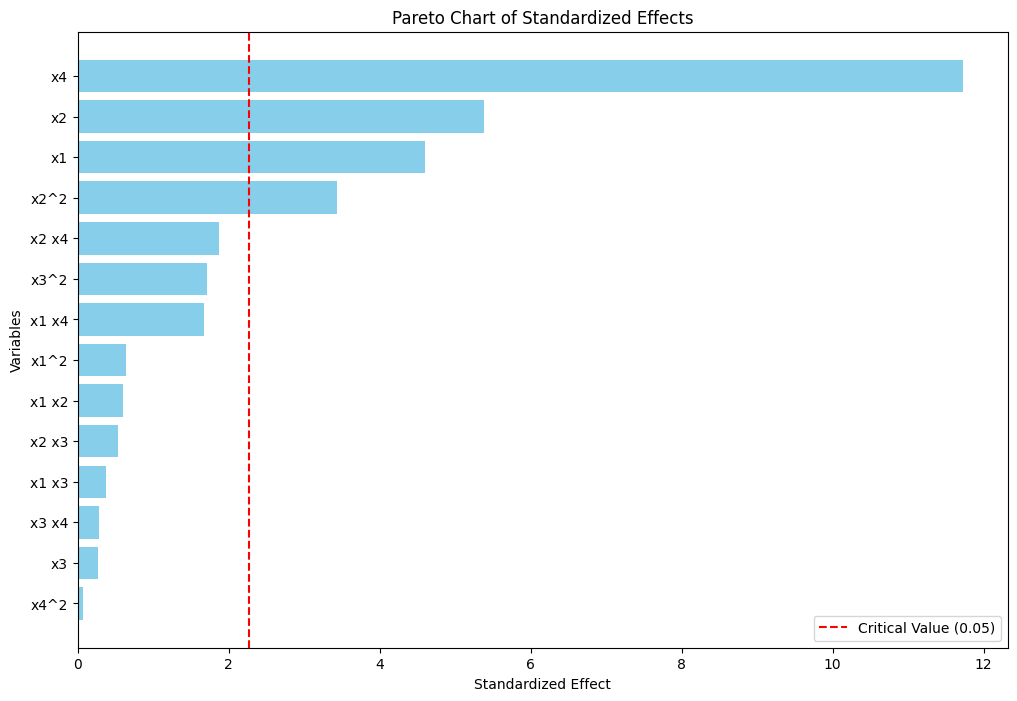

Analysis for response: F3
                            OLS Regression Results                            
Dep. Variable:                     F3   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     2.718
Date:                Sun, 13 Oct 2024   Prob (F-statistic):             0.0678
Time:                        12:55:39   Log-Likelihood:                -14.207
No. Observations:                  24   AIC:                             58.41
Df Residuals:                       9   BIC:                             76.09
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.1230     

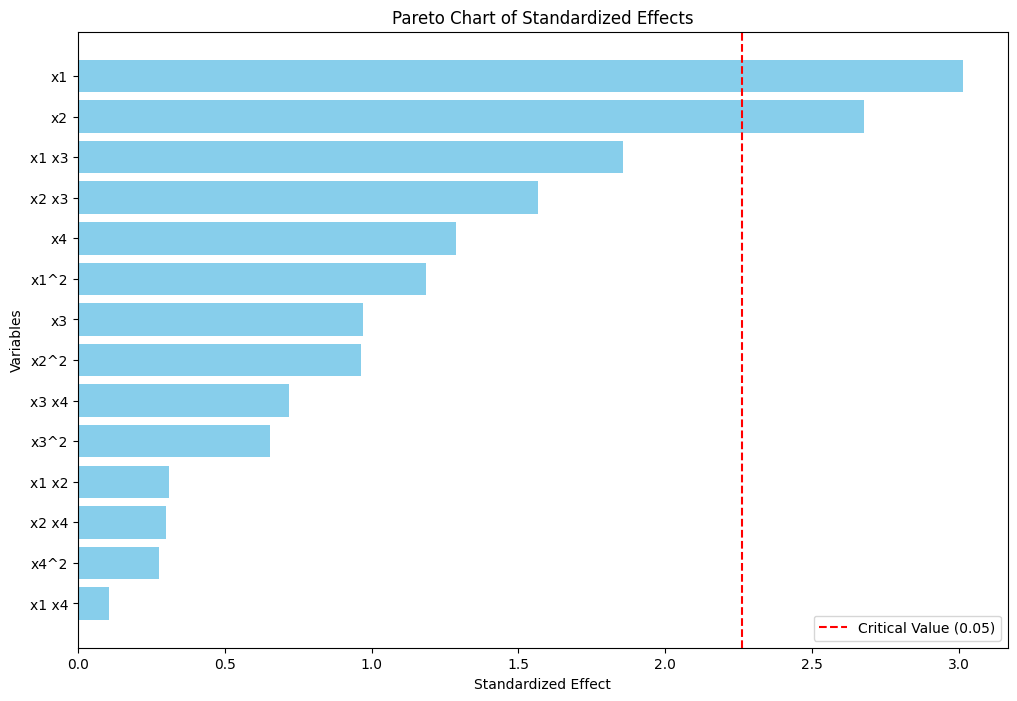


Data Frame with Coefficients:
          COEF(BM)  COEF(MFR)  COEF(T)  COEF(PI)  COEF(MC)  COEF(MTP)  \
constant    10.298     27.006   33.577    38.222    12.082      7.438   
x1           0.020      2.557    6.016     2.041     1.429      0.219   
x2           1.823     -0.474    4.017    -1.210     0.581      1.029   
x3           0.554      1.246    2.658     1.379     0.177      1.011   
x4           2.617      1.126    1.613     0.766     1.345      0.020   
x1^2        -0.050      1.597    1.453     1.914    -0.082      0.209   
x2^2         1.192     -0.907   -2.374    -0.842     0.382     -0.227   
x3^2         0.257     -1.342   -3.550    -0.911     0.089     -0.709   
x4^2         0.006     -0.364   -1.277    -0.253    -0.025     -0.063   
x1 x2        0.000      0.032    1.291     0.232     0.195      0.041   
x1 x3        0.000      1.777    3.696     1.916     0.075      0.297   
x1 x4        0.000     -0.666   -1.705    -0.439     0.341     -0.319   
x2 x3        0.138  

In [7]:
# DOE Analysis

# Function to perform analysis for a specific response
def perform_analysis(response, df):
    # Creating polynomial and interaction features up to degree 2
    poly = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
    df_poly_array = poly.fit_transform(df)
    df_poly = pd.DataFrame(df_poly_array, columns=poly.get_feature_names_out(df.columns))

    # Renaming the first column to "constant"
    df_poly.rename(columns={"1": "constant"}, inplace=True)
    
    # Rearranging the columns: constants, originals, quadratics, interactions
    original_cols = df.columns.tolist()
    quad_cols = [col for col in df_poly.columns if '^2' in col]
    interaction_cols = [col for col in df_poly.columns if col not in ['constant'] + original_cols + quad_cols]

    # Combining the columns in the desired order
    ordered_cols = ['constant'] + original_cols + quad_cols + interaction_cols
    df_poly = df_poly[ordered_cols]

    # Fitting the linear regression model to the data with polynomial and interaction features
    model = sm.OLS(response, df_poly).fit()

    # Printing the model summary
    print(model.summary())

    # Calculating the model coefficients
    coefs = model.params

    # Storing the coefficients in a DataFrame
    df_coef = pd.DataFrame(coefs, columns=['Coefficient'])

    # Calculating the residuals
    residuals = model.resid

    # Creating a DataFrame with the residuals and the fitted values
    fits = model.fittedvalues
    df_resid = pd.DataFrame({'Fit': fits, 'Resid': residuals, 'Std_Resid': model.get_influence().resid_studentized_internal})

    # Identifying outliers based on standardized residuals
    outliers = df_resid[(np.abs(df_resid['Std_Resid']) > 2)]

    # Displaying the outliers
    print("\nOutliers:")
    print(round(outliers, 3))

    # Obtaining the standardized effects of the model
    standardized_effects = np.abs(coefs[1:] / model.bse[1:])
    variable_names = df_poly.columns[1:]

    # Sorting the standardized effects in descending order of magnitude
    sorted_indices = np.argsort(standardized_effects)[::1]
    sorted_effects = standardized_effects[sorted_indices]
    sorted_var_names = variable_names[sorted_indices]

    # Calculating the critical t-value for a significance level of 0.05
    dof = len(response) - len(coefs)  # degrees of freedom
    t_critical = t.ppf(1 - 0.025, dof)

    # Creating the Pareto chart
    plt.figure(figsize=(12, 8))
    plt.barh(sorted_var_names, sorted_effects, color='skyblue')
    plt.axvline(x=t_critical, color='red', linestyle='--', label='Critical Value (0.05)')
    plt.xlabel('Standardized Effect')
    plt.ylabel('Variables')
    plt.title('Pareto Chart of Standardized Effects')
    plt.legend()
    plt.xlim(left=0)  # Keeping the x-axis starting from zero
    plt.grid(False)   # Removing grid lines
    plt.show()

    return df_coef, outliers

# List to store coefficients of all models
all_coefs = []

# Performing analysis for each original response
for response in responses_df.columns:
    print(f"Analysis for response: {response}")
    coefs, outliers = perform_analysis(responses_df[response], df)
    all_coefs.append((response, coefs))

# Performing analysis for each factor
for response in scoresfa_df.columns:
    print(f"Analysis for response: {response}")
    coefs, outliers = perform_analysis(scoresfa_df[response], df)
    all_coefs.append((response, coefs))

coef_dfs = [coefs for _, coefs in all_coefs]

# Creating a DataFrame with coefficients of all models
coef_df = pd.concat(coef_dfs, axis=1)
coef_df.columns = [f'COEF({response})' for response, _ in all_coefs]

print("\nData Frame with Coefficients:")
print(round(coef_df.head(23), 3))

# Saving the results to an Excel file
# coef_df.to_excel("coef_df.xlsx", index=False)

In [8]:
# Simplex-Lattice

# Function to generate the weights of the Simplex Lattice
def generate_simplex_lattice_weights(num_components, num_spacing, prefix=[]):
    if num_components == 1:
        weight = prefix + [num_spacing]
        weights = [weight]
    else:
        weights = []
        for i in range(num_spacing + 1):
            new_prefix = prefix + [i]
            weights.extend(generate_simplex_lattice_weights(num_components - 1, num_spacing - i, new_prefix))
    return weights

def generate_simplex_lattice_weights_df(num_components, num_spacing):
    weights = generate_simplex_lattice_weights(num_components, num_spacing)
    # Convert the weights to be in decimal form and normalize
    normalized_weights = [[w / num_spacing for w in weight] for weight in weights]
    # Sort rows by the descending order of the values in each row
    sorted_weights = sorted(normalized_weights, key=lambda x: tuple(-np.array(x)), reverse=False)
    columns = ['w{}'.format(i+1) for i in range(num_components)]
    weight_df = pd.DataFrame(sorted_weights, columns=columns)
    return weight_df

# Function to get the row 'n' from the DataFrame
def get_row_by_index(df, n):
    if 0 <= n < len(df):
        return df.iloc[n]
    else:
        raise IndexError("Index out of bounds for the DataFrame")

# Defining the number of components and degrees of freedom
num_components = 3
num_spacing = 10

# Generating the DataFrame with the weights of the Simplex Lattice
weight_df = generate_simplex_lattice_weights_df(num_components, num_spacing)

# Displaying the DataFrame
print("DataFrame with the weights of the Simplex Lattice:")
print(round(weight_df.head(20), 3))  # Displaying a larger number of rows to check the sorting

# Printing the number of rows and columns
num_rows, num_columns = weight_df.shape
print("\nNumber of rows:", num_rows)
print("Number of columns:", num_columns)

# Saving the DataFrame to an Excel file
# weight_df.to_excel("weights.xlsx", index=False)

DataFrame with the weights of the Simplex Lattice:
     w1   w2   w3
0   1.0  0.0  0.0
1   0.9  0.1  0.0
2   0.9  0.0  0.1
3   0.8  0.2  0.0
4   0.8  0.1  0.1
5   0.8  0.0  0.2
6   0.7  0.3  0.0
7   0.7  0.2  0.1
8   0.7  0.1  0.2
9   0.7  0.0  0.3
10  0.6  0.4  0.0
11  0.6  0.3  0.1
12  0.6  0.2  0.2
13  0.6  0.1  0.3
14  0.6  0.0  0.4
15  0.5  0.5  0.0
16  0.5  0.4  0.1
17  0.5  0.3  0.2
18  0.5  0.2  0.3
19  0.5  0.1  0.4

Number of rows: 66
Number of columns: 3


In [9]:
# Vector z(x)

# Function to create the z(x) vector
def create_z_vector(x, n_coef):
    z_values = [1]
    z_values.extend(x)
    z_values.extend(x[i] ** 2 for i in range(n_coef))
    for i in range(n_coef):
        for j in range(i + 1, n_coef):
            z_values.append(x[i] * x[j])
    return np.array(z_values)

# Number of coefficients
n_coef = k  # Make sure 'k' is defined earlier in the code

# Vector x
x0 = np.zeros(n_coef)

# Create the z(x) vector
z_vector = create_z_vector(x0, n_coef)

# Transform the z_vector into a DataFrame with a custom column title
z_vector_df = pd.DataFrame(z_vector, columns=["z(x)"])

# Display the DataFrame without the index and without the column title
round(z_vector_df, 3)

# Save the DataFrame to an Excel file
# z_vector_df.to_excel("z(x).xlsx", index=False)

,z(x)
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [10]:
# Individual Optimization

# Objective function for optimization
def objective_function(x, coef, sense):
    z = create_z_vector(x, len(x))
    objective_value = np.dot(coef, z)
    if sense == 'max':
        objective_value *= -1  # Inverting the sign for maximization
    return objective_value

# Constraints: The sum of the squares of xi must be <= 4 (or 2^2)
def constraint(x):
    return 4 - np.sum(np.square(x))

# Initial setup and limits for the variables
n_coef = k
x0 = np.zeros(n_coef)
bounds = [(-2, 2) for _ in range(n_coef)]

# Dictionary to define the sense of optimization for each column
optimization_sense = {
    'COEF(BM)': 'min',
    'COEF(MFR)': 'max',
    'COEF(T)': 'min',
    'COEF(PI)': 'max',
    'COEF(MC)': 'min',
    'COEF(MTP)': 'min',
    'COEF(MMV)': 'max',
    'COEF(ATε)': 'min',
    'COEF(F1)': 'min',
    'COEF(F2)': 'min',
    'COEF(F3)': 'max'
}

# Optimization for each column of coef_df
results = {}
objective_results = {}  # Store the results of the objective function

for column in coef_df.columns:
    coef = coef_df[column].values
    sense = optimization_sense[column]

    # Determining the optimization function: minimization or maximization
    if sense == 'min':
        result = minimize(objective_function, x0, args=(coef, sense), bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})
    elif sense == 'max':
        result = minimize(objective_function, x0, args=(coef, sense), bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})

    results[column] = result
    objective_results[column] = -result.fun if sense == 'max' else result.fun  # Adjusting the sign of the results

# Displaying the results
for column, result in results.items():
    print(f"Optimization for {column}:")
    print(f"  x: {np.round(result.x, 3)}")
    print(f"  Objective Function: {np.round(objective_results[column], 3)}")
    print(f"  Optimization complete? {result.success}\n")

# Preparing the data to save
# Transposing the results DataFrame of x so that variables are in rows
resultados_x = pd.DataFrame({key: result.x for key, result in results.items()})

# Updating the indices to 'x_n'
resultados_x.index = [f'x{i+1}' for i in range(resultados_x.shape[0])]

# Inverting the DataFrame of the objective function results
resultados_objetivo = pd.DataFrame(objective_results, index=['Objective Function']).T

# Saving the results to an Excel file
# with pd.ExcelWriter('individual_optimization.xlsx') as writer:
#     resultados_x.to_excel(writer, sheet_name='Results_x')
#     resultados_objetivo.to_excel(writer, sheet_name='Results_Objective_Function')

Optimization for COEF(BM):
  x: [-0.017 -0.162 -0.163 -1.987]
  Objective Function: 5.015
  Optimization complete? True

Optimization for COEF(MFR):
  x: [1.906 0.032 0.604 0.041]
  Objective Function: 40.005
  Optimization complete? True

Optimization for COEF(T):
  x: [-0.831 -1.101  1.288 -0.663]
  Objective Function: 10.61
  Optimization complete? True

Optimization for COEF(PI):
  x: [1.88  0.012 0.68  0.064]
  Objective Function: 51.812
  Optimization complete? True

Optimization for COEF(MC):
  x: [-1.721 -0.03  -0.002 -1.019]
  Objective Function: 8.578
  Optimization complete? True

Optimization for COEF(MTP):
  x: [ 0.143 -0.796 -1.829 -0.011]
  Objective Function: 2.019
  Optimization complete? True

Optimization for COEF(MMV):
  x: [ 1.846  0.578  0.436 -0.258]
  Objective Function: 15.063
  Optimization complete? True

Optimization for COEF(ATε):
  x: [-0.985 -1.134  1.214 -0.52 ]
  Objective Function: 5.886
  Optimization complete? True

Optimization for COEF(F1):
  x: [ 

In [11]:
# Sumproduct

# Performing the sumproduct
result_sum_product = np.dot(coef_df.values.T, z_vector)

# Transforming the result into a DataFrame
result_sum_product_df = pd.DataFrame(result_sum_product, index=coef_df.columns, columns=["Result"])

# Displaying the DataFrame without the index and with the column title
round(result_sum_product_df, 3)

# Updating the calculation of result_sum_product within the constraint function
def update_result_sum_product(x):
    z_vector = create_z_vector(x, len(x))
    result_sum_product = np.dot(coef_df.values.T, z_vector)
    return result_sum_product

# Saving the DataFrame to an Excel file
# result_sum_product_df.to_excel("sumproduct.xlsx", index=True)

In [12]:
# Payoff Matrix, Utopia and Nadir, and Scaled Payoff

from scipy.optimize import minimize

# Function to create the vector z(x)
def create_z_vector(x, n_coef):
    z_values = [1]
    z_values.extend(x)
    z_values.extend(x[i] ** 2 for i in range(n_coef))
    for i in range(n_coef):
        for j in range(i+1, n_coef):
            z_values.append(x[i] * x[j])
    return np.array(z_values)

# Objective function for optimization
def objective_function(x, coef, sense):
    z = create_z_vector(x, len(x))
    objective_value = np.dot(coef, z)
    if sense == 'max':
        objective_value *= -1  # Inverting the sign for maximization
    return objective_value

# Constraints: The sum of the squares of xi must be <= 4 (or 2^2)
def constraint(x):
    return 4 - np.sum(np.square(x))

# Initial setup and bounds for the variables
n_coef = k  # Make sure k is defined
x0 = np.zeros(n_coef)
bounds = [(-2, 2) for _ in range(n_coef)]

# Identifying the columns of coefficients related to the factors
coef_columns = [col for col in coef_df.columns if col.startswith('COEF(F')]

# Filtering coef_df only for the coefficients of interest
coef_df_interest = coef_df[coef_columns]

# Initializing the payoff matrix DataFrame
payoff_matrix = pd.DataFrame(index=coef_columns, columns=coef_columns)

# Optimization for each coefficient of interest
for column in coef_df_interest.columns:
    sense = optimization_sense.get(column, 'min')  # Default to 'min' if not in the dictionary
    coef = coef_df_interest[column].values

    # Executing the optimization
    result = minimize(objective_function, x0, args=(coef, sense), bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})

    # Saving the optimization results
    z_values = create_z_vector(result.x, n_coef)
    payoff_values = {col: np.dot(coef_df_interest[col].astype(float).values, z_values) for col in coef_df_interest.columns}

    # Adding the results to the payoff matrix DataFrame
    payoff_matrix.loc[column] = payoff_values

# Transposing the payoff matrix
payoff_matrix = payoff_matrix.transpose()

# Converting all values to float to ensure correct data types
payoff_matrix = payoff_matrix.apply(pd.to_numeric, errors='coerce')

# Showing the results of the payoff matrix
print("Payoff Matrix:")
print(round(payoff_matrix, 3))


# Utopia and Pseudo-Nadir

# Determining utopia and pseudo-nadir
utopia = payoff_matrix.max(axis=1)  # Maximum of each row (after transposition)
nadir = payoff_matrix.min(axis=1)  # Minimum of each row (after transposition)

# Applying the optimization sense to determine utopia and nadir
for col in utopia.index:
    if optimization_sense[col] == 'min':
        utopia[col], nadir[col] = nadir[col], utopia[col]

# Showing the results of utopia and nadir
print("\nUtopia and Nadir:")
print(round(pd.DataFrame({'Utopia': utopia, 'Nadir': nadir}), 3))


# Scaled Payoff

# Function to calculate the Scaled Payoff
def calculate_scaled_payoff(payoff_matrix, utopia, nadir):
    # Initializing an empty DataFrame for the scaled payoff
    scaled_payoff = pd.DataFrame(columns=payoff_matrix.columns)

    # Iterating over each row of the payoff matrix
    for idx, row in payoff_matrix.iterrows():
        # Calculating the Scaled Payoff for each coefficient in the row
        scaled_payoff.loc[idx] = (row - utopia[idx]) / (nadir[idx] - utopia[idx])

    return scaled_payoff

# Calculating the Scaled Payoff
scaled_payoff = calculate_scaled_payoff(payoff_matrix, utopia, nadir)

# Showing the results of the Scaled Payoff
print("\nScaled Payoff:")
print(round(scaled_payoff, 3))


# Saving the DataFrame to an Excel file
# payoff_matrix.to_excel("payoff.xlsx", index=False)

Payoff Matrix:
          COEF(F1)  COEF(F2)  COEF(F3)
COEF(F1)    -2.379     0.396     0.906
COEF(F2)     0.252    -2.044     0.181
COEF(F3)     0.199    -0.652     2.602

Utopia and Nadir:
          Utopia  Nadir
COEF(F1)  -2.379  0.906
COEF(F2)  -2.044  0.252
COEF(F3)   2.602 -0.652

Scaled Payoff:
          COEF(F1)  COEF(F2)  COEF(F3)
COEF(F1)     0.000     0.845     1.000
COEF(F2)     1.000     0.000     0.969
COEF(F3)     0.739     1.000    -0.000


In [13]:
# Beta, Phibeta, tnhat, and Fbar

# Initializing the list to store Beta values
beta = []

n = 1

# Obtaining the Beta values from the first row of weight_df for the current iteration (n)
for i in range(num_components):
    # Getting the corresponding w value for the current iteration (n) and column (i)
    w_value = weight_df.iloc[n-1, i]
    
    # Adding the Beta value to the list
    beta.append(w_value)

beta = np.array(beta)

# Displaying the Beta array with rounded values
beta_df = pd.DataFrame(beta, columns=["Beta"], index=weight_df.columns)
print("Beta:")
print(round(beta_df, 3))


# Phibeta

# Calculating phi_beta
phi_beta = np.dot(scaled_payoff.values, beta)

# Function to calculate phi_beta
def calculate_phi_beta(x):
    result_sum_product = update_result_sum_product(x)
    return np.dot(scaled_payoff.values, beta)

# Displaying the DataFrame with rounded values
phi_beta_df = pd.DataFrame(phi_beta, columns=["𝚽 ̅𝛃"], index=payoff_matrix.columns)
print("\nPhi Beta:")
print(round(phi_beta_df, 3))


# tnhat

# Creating a zero vector of the same size as beta
tn_hat = np.zeros(len(beta))

# Calculating tn_hat
tn_hat = scaled_payoff.dot(tn_hat)
tn_hat = tn_hat.to_numpy()

# Function to calculate tn_hat
def calculate_tn_hat(x):
    result_sum_product = update_result_sum_product(x)
    tn_hat = np.zeros(len(beta))
    tn_hat = scaled_payoff.dot(tn_hat)
    return tn_hat.to_numpy()

# Displaying the result of tn_hat directly with rounded values
tn_hat_df = pd.DataFrame(tn_hat, columns=["𝑡𝐧"], index=payoff_matrix.columns)
print("\ntn hat:")
print(round(tn_hat_df, 3))


# Fbar(x)

# Extracting the factors of interest from coef_df columns
factors = [col for col in coef_df.columns if col.startswith('COEF(F')]

# Initializing the array to store the results of F_bar
F_bar = np.full(len(factors), np.nan)

# Calculating F_bar for each factor
for idx, factor in enumerate(factors):
    result = result_sum_product[coef_df.columns.get_loc(factor)]
    utopia_val = utopia.get(factor, np.nan)
    nadir_val = nadir.get(factor, np.nan)
    if not np.isnan(utopia_val) and not np.isnan(nadir_val):
        F_bar[idx] = (result - utopia_val) / (nadir_val - utopia_val)

# Function to calculate F_bar
def calculate_F_bar(x):
    result_sum_product = update_result_sum_product(x)
    factors = [col for col in coef_df.columns if col.startswith('COEF(F')]
    F_bar = np.full(len(factors), np.nan)
    for idx, factor in enumerate(factors):
        result = result_sum_product[coef_df.columns.get_loc(factor)]
        utopia_val = utopia.get(factor, np.nan)
        nadir_val = nadir.get(factor, np.nan)
        if not np.isnan(utopia_val) and not np.isnan(nadir_val):
            F_bar[idx] = (result - utopia_val) / (nadir_val - utopia_val)
    return F_bar

# Displaying F_Bar
F_bar_df = pd.DataFrame(F_bar, columns=["𝐅 ̅"], index=payoff_matrix.columns)
print("\nF bar:")
print(round(F_bar_df, 3))

Beta:
    Beta
w1   1.0
w2   0.0
w3   0.0

Phi Beta:
           𝚽 ̅𝛃
COEF(F1)  0.000
COEF(F2)  1.000
COEF(F3)  0.739

tn hat:
           𝑡𝐧
COEF(F1)  0.0
COEF(F2)  0.0
COEF(F3)  0.0

F bar:
            𝐅 ̅
COEF(F1)  0.871
COEF(F2)  0.680
COEF(F3)  0.762


In [14]:
# Constraints

# Calculating the constraints
constraintgn = phi_beta + tn_hat - F_bar
constraintg1 = np.sum(np.square(x0))

# Constraint function g1(x)
def constraint1(x):
    return 4 - np.sum(np.square(x))

# Constraint function g2(x) to gn(x)
def constraintn(x):
    # Update phi_beta, tn_hat, and F_bar based on x
    phi_beta = calculate_phi_beta(x)
    tn_hat = calculate_tn_hat(x)
    F_bar = calculate_F_bar(x)
    return phi_beta + tn_hat - F_bar

# Creating the DataFrame for the constraints with g1(x) before gn(x)
constraints_df = pd.DataFrame({
    'gn(x)': np.concatenate(([constraintg1], constraintgn)),
}, index=['g1(x)'] + [f'g{i+2}(x)' for i in range(len(constraintgn))])

# Displaying the DataFrame with rounded values
print("Constraints:")
print(round(constraints_df, 3))

Constraints:
       gn(x)
g1(x)  0.000
g2(x) -0.871
g3(x)  0.320
g4(x) -0.023


In [15]:
# Normal Boundary Intersection

# Creation of Slack and T
Slack = 0
T = 0

# Objective function (maximize T)
def objective(x):
    T = Slack + 0 + sum(x) - sum(x) 
    return -T 

# Initial settings
n_coef = k  
x0 = np.zeros(n_coef)
limits = [(-2, 2) for _ in range(n_coef)]

# Initializing the DataFrame to store results of all iterations
cumulative_results = pd.DataFrame()

# Iterating over each row of weight_df
for n in range(len(weight_df)):
    # Updating the value of beta with row 'n' from weight_df
    beta = weight_df.iloc[n].values

    # Defining the constraints for the optimizer
    g1 = {'type': 'ineq', 'fun': constraint1}
    gn = {'type': 'eq', 'fun': constraintn}

    # Executing the optimization
    result = minimize(
        objective,
        x0,
        method='SLSQP',
        constraints=[g1, gn],
        bounds=limits,
        options={'maxiter': 1000, 'ftol': 1e-6}
    )

    # Updating x0 with the result of the current iteration
    x0 = result.x

    # Calculating the results for display
    sum_product_result = update_result_sum_product(result.x)
    constraint_1 = constraint1(result.x)
    constraint_n = constraintn(result.x)

    # Storing the results of the current iteration
    iteration_df = pd.DataFrame({
        'n': [n + 1],  # Adds n, incremented by 1 to start from 1
        **{f'w{i+1}': [weight_df.iloc[n, i]] for i in range(len(weight_df.columns))}, 
        **{f'x{i+1}': [val] for i, val in enumerate(result.x)},
        **{coef_df.columns[i]: [val] for i, val in enumerate(sum_product_result)},
        'g1(x)': [constraint_1],
        **{f'g{i+2}(x)': [val] for i, val in enumerate(constraint_n)}
    })

    # Adding the iteration to the cumulative DataFrame
    cumulative_results = pd.concat([cumulative_results, iteration_df], ignore_index=True)

# Adjusting the index to start at 1
cumulative_results.index += 1

# Printing the results
round(cumulative_results, 3)

# Storing results in Excel
# cumulative_results.to_excel("cumulative_results.xlsx", index=False)

,n,w1,w2,w3,x1,x2,x3,x4,COEF(BM),COEF(MFR),...,COEF(MTP),COEF(MMV),COEF(ATε),COEF(F1),COEF(F2),COEF(F3),g1(x),g2(x),g3(x),g4(x)
1,1,1.0,0.0,0.0,0.177,-1.101,-1.639,0.265,10.230,22.705,...,2.187,6.128,5.960,-2.379,0.252,0.199,-0.000,-0.0,0.0,0.0
2,2,0.9,0.1,0.0,0.052,-0.914,-1.650,0.065,9.743,22.577,...,2.504,6.577,6.516,-2.102,0.022,0.114,0.436,0.0,-0.0,-0.0
3,3,0.9,0.0,0.1,0.265,-1.473,-1.154,0.293,10.598,24.670,...,3.060,7.273,6.427,-2.051,0.245,0.439,0.344,-0.0,-0.0,-0.0
4,4,0.8,0.2,0.0,-0.630,-0.559,-1.808,0.152,9.908,22.554,...,2.854,6.829,7.271,-1.824,-0.207,0.029,-0.000,-0.0,0.0,0.0
5,5,0.8,0.1,0.1,-0.625,-0.996,-1.427,0.762,10.961,24.629,...,3.521,7.447,6.795,-1.773,0.015,0.354,-0.000,0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,0.0,0.4,0.6,1.344,-0.353,-0.031,-0.528,8.461,33.018,...,7.845,13.155,15.650,0.702,-0.709,1.300,1.789,0.0,0.0,-0.0
63,63,0.0,0.3,0.7,1.533,-0.294,0.040,-0.311,9.041,34.774,...,8.119,13.529,16.580,0.753,-0.486,1.626,1.466,0.0,0.0,-0.0
64,64,0.0,0.2,0.8,1.708,-0.218,0.114,-0.114,9.625,36.507,...,8.397,13.889,17.535,0.804,-0.264,1.951,1.011,0.0,-0.0,-0.0
65,65,0.0,0.1,0.9,1.871,-0.128,0.192,0.062,10.217,38.220,...,8.674,14.232,18.524,0.855,-0.041,2.277,0.442,0.0,-0.0,-0.0


In [16]:
# Metrics

# Function to calculate the normalized Euclidean distance (NED)
def normalized_euclidean_distance(result_sum_product, utopia):
    factors = [col for col in coef_df.columns if col.startswith('COEF(F')]
    utopia_values = np.array([utopia.get(factor, 1) for factor in factors])
    results_values = np.array([result_sum_product[factor] for factor in factors])
    
    if len(results_values) != len(utopia_values):
        raise ValueError("The number of factors does not match the number of results.")
    
    # Calculate the normalized Euclidean distance
    normalized_diff = (results_values - utopia_values) / utopia_values
    ned = np.sqrt(np.sum(normalized_diff ** 2))
    return ned

# Function to calculate the global percentage error (GPE)
def global_percentual_error(result_sum_product, utopia):
    factors = [col for col in coef_df.columns if col.startswith('COEF(F')]
    utopia_values = np.array([utopia.get(factor, 1) for factor in factors])
    results_values = np.array([result_sum_product[factor] for factor in factors])
    
    if len(results_values) != len(utopia_values):
        raise ValueError("The number of factors does not match the number of results.")
    
    # Calculating the global percentage error
    percentual_error = np.abs(results_values / utopia_values - 1)
    gpe = np.sum(percentual_error)
    return gpe

# Function to calculate Shannon entropy (S)
def entropy_shannon(weights):
    weights = np.array(weights)
    try:
        # Filter out zeros to avoid log(0)
        non_zero_weights = weights[weights > 0]
        s = -np.sum(non_zero_weights * np.log(non_zero_weights))
    except Exception as e:
        print(f"Error calculating Shannon Entropy: {e}")
        s = 0
    return s

# Function to calculate Mahalanobis distance (MD)
def calculate_mahalanobis_distance(row, mean, inv_cov_matrix):
    x = np.array(row)
    return mahalanobis(x, mean, inv_cov_matrix)

# Calculating the covariance matrix based on COEF(F1) to COEF(Fn)
coef_cols = [col for col in coef_df.columns if col.startswith('COEF(F')]
cov_matrix = np.cov(cumulative_results[coef_cols].values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculating the mean of the columns COEF(F1) to COEF(Fn)
mean = cumulative_results[coef_cols].mean().values

# Adding the metrics to the DataFrame
cumulative_results['NED'] = cumulative_results.apply(
    lambda row: normalized_euclidean_distance(
        row[[col for col in coef_df.columns if col.startswith('COEF(F')]],
        utopia
    ),
    axis=1
)

# Adding the GPE metric to the cumulative_results DataFrame
cumulative_results['GPE'] = cumulative_results.apply(
    lambda row: global_percentual_error(
        row[[col for col in coef_df.columns if col.startswith('COEF(F')]],
        utopia
    ),
    axis=1
)

cumulative_results['S'] = cumulative_results.apply(
    lambda row: entropy_shannon(np.array([row[col] for col in weight_df.columns])),
    axis=1
)

cumulative_results['S/GPE'] = cumulative_results.apply(
    lambda row: row['S'] / row['GPE'] if row['GPE'] != 0 else np.nan,
    axis=1
)

# Adding the Mahalanobis distance to the DataFrame
cumulative_results['MD'] = cumulative_results.apply(
    lambda row: calculate_mahalanobis_distance(
        [row[col] for col in coef_cols],
        mean,
        inv_cov_matrix
    ),
    axis=1
)

# Printing the DataFrame with all metrics
round(cumulative_results, 3)

# Storing results in Excel
# cumulative_results.to_excel("cumulative_results.xlsx", index=False)

,n,w1,w2,w3,x1,x2,x3,x4,COEF(BM),COEF(MFR),...,COEF(F3),g1(x),g2(x),g3(x),g4(x),NED,GPE,S,S/GPE,MD
1,1,1.0,0.0,0.0,0.177,-1.101,-1.639,0.265,10.230,22.705,...,0.199,-0.000,-0.0,0.0,0.0,1.454,2.047,-0.000,-0.000,2.551
2,2,0.9,0.1,0.0,0.052,-0.914,-1.650,0.065,9.743,22.577,...,0.114,0.436,0.0,-0.0,-0.0,1.396,2.084,0.325,0.156,2.181
3,3,0.9,0.0,0.1,0.265,-1.473,-1.154,0.293,10.598,24.670,...,0.439,0.344,-0.0,-0.0,-0.0,1.401,2.089,0.325,0.156,2.187
4,4,0.8,0.2,0.0,-0.630,-0.559,-1.808,0.152,9.908,22.554,...,0.029,-0.000,-0.0,0.0,0.0,1.356,2.121,0.500,0.236,1.840
5,5,0.8,0.1,0.1,-0.625,-0.996,-1.427,0.762,10.961,24.629,...,0.354,-0.000,0.0,-0.0,-0.0,1.351,2.126,0.639,0.301,1.796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,0.0,0.4,0.6,1.344,-0.353,-0.031,-0.528,8.461,33.018,...,1.300,1.789,0.0,0.0,-0.0,1.534,2.448,0.673,0.275,1.308
63,63,0.0,0.3,0.7,1.533,-0.294,0.040,-0.311,9.041,34.774,...,1.626,1.466,0.0,0.0,-0.0,1.567,2.454,0.611,0.249,1.501
64,64,0.0,0.2,0.8,1.708,-0.218,0.114,-0.114,9.625,36.507,...,1.951,1.011,0.0,-0.0,-0.0,1.616,2.459,0.500,0.204,1.777
65,65,0.0,0.1,0.9,1.871,-0.128,0.192,0.062,10.217,38.220,...,2.277,0.442,0.0,-0.0,-0.0,1.680,2.464,0.325,0.132,2.104
